<a href="https://colab.research.google.com/github/qmeng222/transformers-for-NLP/blob/main/Seq2Seq/Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install libraries:
!pip install transformers datasets sentencepiece
# `transformers` library: for using pre-trained models
# `datasets` library: to access a collection of high-quality datasets for NLP tasks
# `sentencepiece` library: to tokenize text into subwords

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00


# Load the dataset & split it into training and testing sets:

The process of loading a dataset might implicitly involve downloading it if the dataset is not already present on your system.

In [2]:
from datasets import load_dataset # from the library, import the function

# [Reference] possible language pairs: https://opus.nlpl.eu/KDE4.php
data = load_dataset("kde4", lang1="en", lang2="fr") # load a dataset named "kde4" with specific language configurations
data

Generating train split:   0%|          | 0/210173 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

👆 Too many samples!

In [3]:
small = data["train"].shuffle(seed=42).select(range(1_000)) # create a smaller, shuffled subset of the training data
# .shuffle(): this method shuffles the training examples
# seed=42: the seed parameter is set to 42 to ensure reproducibility
# .select(range(1_000)): selects the first 20,000 examples (0-999)
small

Dataset({
    features: ['id', 'translation'],
    num_rows: 1000
})

In [4]:
# split dataset ('small') into training and testing sets:
split = small.train_test_split(seed=42) # ensure the split is reproducible
split

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 750
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 250
    })
})

In [5]:
# check the 1st example from the training set:
split["train"][0]

{'id': '169005',
 'translation': {'en': '& Reduce Tree', 'fr': "& Refermer l' arborescence"}}

# Load the tokenizer:

In [6]:
from transformers import AutoTokenizer # import the class, enabling dynamic loading of tokenizer for a specific pre-trained model

checkpoint = "Helsinki-NLP/opus-mt-en-fr" # model identifier (specify the name of a pre-trained model)
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # automatically load the appropriate tokenizer

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


# Prepare the model inputs:

In [7]:
# check the 6th example from the training set:
split["train"][5]

{'id': '46472',
 'translation': {'en': 'You can either pick a file or enter its name in the Location: box.',
  'fr': 'Vous pouvez soit choisir un fichier soit saisir son nom dans la zone de texte Emplacement.'}}

In [8]:
# extract the English and French translation texts from the 6th example (idx=5):
en = split['train'][5]['translation']['en']
fr = split['train'][5]['translation']['fr']
en, fr

('You can either pick a file or enter its name in the Location: box.',
 'Vous pouvez soit choisir un fichier soit saisir son nom dans la zone de texte Emplacement.')

In [9]:
# tokenize the English translation text -> the input tokens (into a machine learning model)
inputs = tokenizer(en)
inputs

{'input_ids': [213, 115, 1828, 8437, 15, 1437, 57, 3307, 96, 1129, 18, 4, 4577, 37, 5311, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

👆 Note: it comes with an attention mask

In [10]:
# tokenize the French translation text -> the target tokens
targets = tokenizer(text_target=fr) # NOTE: must specify `text_target` here!
targets

{'input_ids': [344, 1069, 345, 4094, 34, 2428, 345, 9315, 113, 689, 31, 8, 1283, 5, 1470, 21708, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

👆 `targets` is a dictionary obtained from tokenizing some text,

and 'input_ids' is a key in this dictionary.

The value associated with this key is **a sequence of token IDs**.

In [11]:
# just for checking purpose, convert ids back into string tokens:
# the `convert_ids_to_tokens` method is a functionality provided by `tokenizer`
# it takes a sequence of token ids & returns the corresponding tokens in a human-readable format
tokenizer.convert_ids_to_tokens(targets['input_ids'])

['▁Vous',
 '▁pouvez',
 '▁soit',
 '▁choisir',
 '▁un',
 '▁fichier',
 '▁soit',
 '▁saisir',
 '▁son',
 '▁nom',
 '▁dans',
 '▁la',
 '▁zone',
 '▁de',
 '▁texte',
 '▁Emplacement',
 '.',
 '</s>']

Matches the print out in line 10 🎉

one word -> one string token ✅

In [12]:
# (wrong) demo: What will happen if we didn't specify `text_target` in line 21?
bad_targets = tokenizer(fr) # should be `targets = tokenizer(text_target=fr)` instead
tokenizer.convert_ids_to_tokens(bad_targets['input_ids'])

['▁V',
 'ous',
 '▁po',
 'uv',
 'ez',
 '▁so',
 'it',
 '▁cho',
 'is',
 'ir',
 '▁un',
 '▁fi',
 'chi',
 'er',
 '▁so',
 'it',
 '▁s',
 'ais',
 'ir',
 '▁son',
 '▁no',
 'm',
 '▁dans',
 '▁la',
 '▁zone',
 '▁de',
 '▁text',
 'e',
 '▁Em',
 'placement',
 '.',
 '</s>']

👆 Not completely fail.

However, one word -> multiple string tokens ❌

In [19]:
import matplotlib.pyplot as plt # from the matplotlib library, import the pyplot module for data visualization

In [22]:
# scratch:
split

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 750
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 250
    })
})

In [23]:
# scratch:
split['train']['translation'][9]

{'en': 'Creating new Data CD Project.',
 'fr': "Création d'un nouveau projet de CD de données."}

In [25]:
# retrieve 'translation' features of the training subset:
train = split['train']['translation']

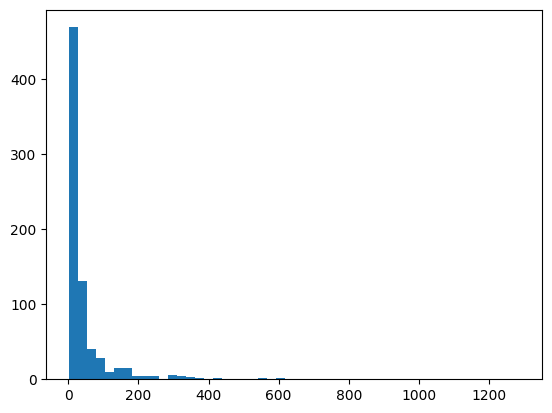

In [27]:
# histogram to check the (English) input lengths:
input_lens = [len(tr['en']) for tr in train]
plt.hist(input_lens, bins=50);  # `;` suppresses output of the last expression

👆 The majority of input lengths fall below 100.

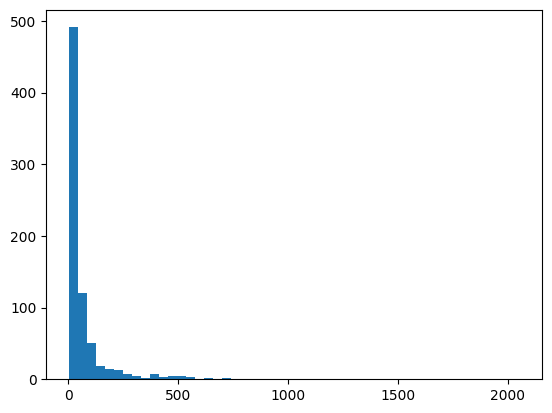

In [28]:
# histogram to check the (French) target lengths:
target_lens = [len(tr['fr']) for tr in train]
plt.hist(target_lens, bins=50);

👆 The majority of target lengths fall below 150.

# Tokenizer function:

In [31]:
max_input_len = 128
max_target_len = 128

def tokenizer_fn(batch):
  inputs = [x['en'] for x in batch['translation']]
  targets = [x['fr'] for x in batch['translation']]

  # tokenize the inputs:
  tokenized_inputs = tokenizer(
    inputs, max_length=max_input_len, truncation=True)
  print(tokenized_inputs)

  # tokenize the targets:
  tokenized_targets = tokenizer(
    text_target=targets, max_length=max_target_len, truncation=True)
  print(tokenized_targets)

  tokenized_inputs['labels'] = tokenized_targets['input_ids'] # ignore attention masks
  return tokenized_inputs

# Apply the tokenizer:

In [30]:
# apply a function (`tokenizer_fn`) to each example in the dataset (`split`) & save as a new dataset (`tokenized_datasets`):
tokenized_datasets = split.map(
    tokenizer_fn,
    batched=True, # apply tokenization function to examples in batches rather than individually
    remove_columns=split['train'].column_names, # specify the columns to be removed from the resulting tokenized dataset
)

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

{'input_ids': [[402, 34933, 29244, 0], [526, 3261, 0], [3492, 3070, 6443, 37, 443, 61, 32, 317, 2203, 4824, 514, 1807, 971, 4, 4124, 3, 0], [2167, 1398, 0], [526, 3261, 11223, 80, 532, 51, 1430, 2652, 0], [213, 115, 1828, 8437, 15, 1437, 57, 3307, 96, 1129, 18, 4, 4577, 37, 5311, 3, 0], [5559, 84, 1323, 0], [18961, 124, 16945, 9, 64, 301, 548, 0], [3107, 24, 14135, 12222, 75, 41085, 28, 0], [31780, 191, 3492, 3571, 3298, 3, 0], [17006, 0], [3321, 16999, 12, 12802, 3795, 4004, 12, 0], [23797, 3493, 0], [1715, 2, 11317, 2, 4469, 21, 31713, 2, 170, 2131, 1345, 0], [42530, 1777, 5149, 12, 16359, 9, 48, 15, 1497, 3, 2253, 16359, 1777, 32, 6372, 2, 170, 16359, 9, 52, 30297, 71, 98, 3, 2253, 16359, 1777, 32, 11415, 24, 776, 2751, 318, 119, 98, 16359, 9, 85, 52, 73, 13897, 6372, 86, 17214, 71, 4, 912, 1377, 3, 0], [249, 9490, 31293, 20570, 0], [4484, 1863, 12, 7293, 31111, 1317, 8658, 0], [402, 4484, 12079, 23409, 0], [443, 67, 5311, 32, 15108, 4, 10014, 25526, 86, 1680, 48, 4212, 2370, 232, 4

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

{'input_ids': [[3982, 994, 0], [13572, 7823, 37, 0], [646, 0], [6703, 962, 51, 7823, 514, 2089, 3, 0], [24828, 3954, 4, 402, 2758, 0], [33260, 108, 37, 12650, 7735, 12, 26484, 37, 301, 548, 32, 73, 6647, 1822, 14808, 8245, 0], [24, 222, 28, 1895, 19930, 2, 6509, 526, 10721, 483, 4334, 108, 0], [16897, 0], [402, 24483, 4703, 5180, 253, 37, 0], [23845, 12416, 5018, 0], [11157, 270, 518, 7, 6042, 12, 1680, 30, 4, 14395, 3, 0], [12566, 8558, 477, 101, 0], [43307, 37, 0], [1113, 3897, 48601, 0], [21984, 253, 365, 7, 14849, 329, 4941, 0], [21829, 482, 7321, 0], [402, 18903, 313, 5625, 50, 32, 4, 3003, 1233, 26, 1760, 155, 587, 3, 138, 22445, 4, 276, 21, 14663, 402, 2635, 511, 50, 1664, 26, 2752, 2, 36658, 2, 1144, 3006, 2, 2058, 2, 10, 3405, 10624, 9, 24, 720, 1874, 50, 2, 402, 2635, 20611, 14464, 50, 2, 402, 2635, 46122, 8881, 50, 2, 402, 47975, 114, 50, 2, 10, 402, 2635, 1506, 511, 50, 28, 208, 15, 1690, 7907, 3, 17336, 731, 30, 15, 2756, 4852, 1212, 402, 18903, 313, 5625, 50, 1252, 6352, 

# Load the pretrained model:

In [33]:
from transformers import AutoModelForSeq2SeqLM # a class for loading pre-trained sequence-to-sequence language model

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint) # load a pre-trained model specified by the `checkpoint`

# Data collator:

A component that processes and organizes input data before feeding it into a model for training or evaluation.
*   Batch creation
*   Padding (per batch)
*   Handling special tokens
*   Converting data to torch tensors

In [34]:
from transformers import DataCollatorForSeq2Seq # a class for combining a batch of examples into a format suitable for training

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model) # create an instance of the class for sequence-to-sequence tasks
# the tokenizer used to process the input and output data
# the model that will be used

In [35]:
# check some tokenized training data:
[tokenized_datasets["train"][i] for i in range(1, 3)]

[{'input_ids': [526, 3261, 0],
  'attention_mask': [1, 1, 1],
  'labels': [526, 3261, 0]},
 {'input_ids': [3492,
   3070,
   6443,
   37,
   443,
   61,
   32,
   317,
   2203,
   4824,
   514,
   1807,
   971,
   4,
   4124,
   3,
   0],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'labels': [34023,
   5,
   3948,
   5,
   372,
   402,
   38492,
   350,
   823,
   95,
   13439,
   2,
   25985,
   14,
   6,
   3996,
   3,
   0]}]

👆 It's a list of dictionaries.

Each dict corresponds to a sample.

And each sample consists 3 fields (input_ids, attention_mask, labels).

In [44]:
# test the data collator on the above inputs:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

👆 4 fields now (field 'decoder_input_ids' was added)

'decoder_input_ids' is the input for the decoder

👆 Great, they are tensors!

In [46]:
# check the 'decoder_input_ids' field of the collated batch:
batch["decoder_input_ids"]

tensor([[59513,   526,  3261,     0, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513],
        [59513, 34023,     5,  3948,     5,   372,   402, 38492,   350,   823,
            95, 13439,     2, 25985,    14,     6,  3996,     3]])

👆 59513 is a special token. It's both the ***start token*** and the ***padding token*** for each sentence

In [53]:
# decoder input IDs -> human-readable tokens:
tokenizer.convert_ids_to_tokens(batch["decoder_input_ids"][0])

['<pad>',
 '▁K',
 'DE',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [45]:
# check the 'labels' field of the collated batch:
batch["labels"]

tensor([[  526,  3261,     0,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
        [34023,     5,  3948,     5,   372,   402, 38492,   350,   823,    95,
         13439,     2, 25985,    14,     6,  3996,     3,     0]])

👆 Again, each sentence had 59513 padding tokens ***added to both the beginning and the end***.

In [51]:
# token IDs -> human-readable tokens:
tokenizer.convert_ids_to_tokens(batch["labels"][0])

['▁K',
 'DE',
 '</s>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>']

👆 The targets are just a shifted version of the decoder inputs.

`'<unk>'` for unknown

In [54]:
split['train'][1]

{'id': '47571', 'translation': {'en': 'KDE', 'fr': 'KDE'}}

# Translation metrics:

In [55]:
# install packages:
!pip install sacrebleu bert-score
# sacrebleu is focused on the BLEU metric for translation evaluation
# bert-score provides evaluation metrics using contextual embeddings, particularly BERT embeddings

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.4 MB/s eta 0:00:00


In [56]:
from datasets import load_metric # a library to load evaluation metrics

bleu_metric = load_metric("sacrebleu") # load metrics for evaluating translation outputs based on the BLEU metric
bert_metric = load_metric("bertscore") # load metrics for evaluating text generation outputs using BERT embeddings

<ipython-input-56-ea55910897b9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu") # load metrics for evaluating translation outputs based on the BLEU metric


In [64]:
# dummy test for a short sentence:
bleu_metric.compute(predictions=["I love cats"], references=[["I love cats"]])
# Note: references/targets must be in a list. Because for BLEU, there can be multiple acceptable reference translations.

{'score': 0.0,
 'counts': [3, 2, 1, 0],
 'totals': [3, 2, 1, 0],
 'precisions': [100.0, 100.0, 100.0, 0.0],
 'bp': 1.0,
 'sys_len': 3,
 'ref_len': 3}

In [65]:
# dummy test for a longer sentence:
s = "Marian is an efficient NMT framework written in pure C++"
bleu_metric.compute(predictions=[s], references=[[s]])

{'score': 100.00000000000004,
 'counts': [12, 11, 10, 9],
 'totals': [12, 11, 10, 9],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 12,
 'ref_len': 12}

In [66]:
# compute BERTScore for a set of predictions and their corresponding references:
bert_metric.compute(
    predictions=["I love cats"], references=[["I like cats"]], lang='en') # 'like' vs 'love'

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.9803367853164673],
 'recall': [0.9803367853164673],
 'f1': [0.9803367853164673],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.35.2)'}

In [67]:
import numpy as np # import NumPy library for numerical computations in Python

# define my own compute_metrics function:
def compute_metrics(preds_and_labels):
  # preds are not logits, but token ids
  preds, labels = preds_and_labels

  # convert predictions into words
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

  # tokenizer doesn't recognize -100 values
  # therefore replace any -100 in labels with the padding token id from a tokenizer
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

  # decode labels into words (human-readable text)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # get rid of extraneous whitespace
  # and also, put targets into lists
  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [[label.strip()] for label in decoded_labels]

  bleu = bleu_metric.compute(
      predictions=decoded_preds, references=decoded_labels)
  bert_score = bert_metric.compute(
      predictions=decoded_preds, references=decoded_labels, lang='fr')

  return {"bleu": bleu["score"], 'bert_score': np.mean(bert_score['f1'])}

👆 Recall that the bert_score is returned per sample, so we calculate the mean.